![alt text](img/LM.png)
# Kurs: Deep Learning, Text Mining i XAI w Pythonie

## Autor: Piotr Ćwiakowski

### Lekcja 3. Zaawansowany ensembling

#### Spis treści:
1. Wprowadzenie
1. Extreme Randomize Trees
2. XGBoost
3. LightGBM
4. Catboost

# 1 Wprowadzenie

Metody kombinowania/uśredniania prognoz (z ang. *ensembling*) okazały być się najlepszym rozwiązaniem w tworzeniu modeli dla płaskich danych tabelarycznych. Łączą w sobie trzy cechy:

- względną prostotę (w porównaniu z sieciami neuronowymi),
- względnie małe ryzyko przetrenowania i konsekwencji z tego wynikających,
- względnie wysokie/optymalne dopasowanie bez tuningu hiperparametrów.

Na kursie podstawowym *Warsztaty Machine Learning w R* omówiliśmy najważniejsze i najpopularniejsze metody (lasy losowe, xgboost, stacking/blending). Teraz poznaj inne, używane nieco rzadziej ale które czasami mogą okazać sie skuteczniejsze lub są po prostu nowszymi propozycjami. Zacznijmy od wczytania pakietów i przygotowania danych.

## 1.1 Pakiety

In [1]:
# Podstawowe pakiety
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia graficzne
sns.set(style='whitegrid')
sns.set_palette("bright")
%matplotlib inline

# Machine Learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Modele ML
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier # UWAGA! Żeby pakiet działał najlepiej włączyć go z uprawnieniami administratora
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from helpers import run_xgb
from helpers2 import plotROCs

## 1.2 Przygotowanie danych

In [2]:
df = pd.read_csv("data/bank-balanced.csv")

target = "deposit"
numFeatures = ['age', 'balance', 'duration', 'campaign', 'pdays','previous', 'day']
catFeatures = [ 'job', 'marital', 'education', 'default',  'housing', 'loan', 'contact',  'month', 'poutcome']

df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

for feature in catFeatures:
    le = preprocessing.LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    
features = df.columns.tolist()
features.remove(target)
print(features)
print(df.shape)
df.head()

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


# 2 Extremely Randomized Forest

Istnieje wiele odmian lasów losowych:
1. Lasy losowe (algorytm Breinmana) – klasyczna i najpopularniejsza implementacja modelu. Dostę
2. Extremely randomized forest – metoda opublikowana w artykule (Geurtsa et al. 2006), czasem może dać odrobinę lepsze wyniki niż klasyczne lasy losowe.
3. Conditional inference forest – metoda oparta o algorytm conditional inference trees, wolniejsza, ale potencjalnie dokładniejsza od lasów losowych.
4. Oblique forest – lasy losowe, w których pojedyncze podziały są wykonywane na podstawie równania liniowego wielu zmiennych, które dodatkowo jest regularyzowane (zobacz Menze et al. 2011)
5. Causal Random Forest (honest causal forest) – wykorzystywane w modelowaniu eksperymentów, kiedy celem jest zaprognozowanie efektu interwencji dla nowych obserwacji.
6. Isolation Forest - wykorzystywane do prób niezbalansowanych i detekcji anomalii. Opiera się na założeniu, że anomalie i klasy mniejszościowe mogą być identyfikowane za pomocą relatywnie nie wielu podziałów (w odróżnieniu od klasy/klas większościowych). W istocie jest algorytmem nienadzorowanym, ponieważ a priori model nie wie, co jest normalną obserwacją a co anomalią.

Jak widać z powyższych opisów, część algorytmów jest stworzona do rozwiązywania bardzo specyficznych problemów (5. i 6.), część nie zdobyła szerszego uznania (3. i 4.), natomiast bardzo ciekawą propozycją są tzw. *ExtraTrees* czyli *Extremely randomized forest*.

Poniżej opis algorytmu:
<img src="img/extratree1.png" width="30%">
Źródło: Geurts, Pierre, Damien Ernst, and Louis Wehenkel. "Extremely randomized trees." Machine learning 63.1 (2006): 3-42.!

Kluczowe  hiperparametry: 
* K – liczba zmiennych w węźle decyzyjnym, 
* nmin – minimalna liczba obserwacji na liściu
* M – liczba drzew w lesie losowym

Podsumowanie modelu:
* drzewa są szacowane na całej, a nie bootstrapowanej próbie (niższy bias)
* M -  liczba drzew redukuje variance (jak w oryginalnym lesie losowym Breinmana)
* K – steruje siłą selekcji zmiennych przy budowie drzew (jak w oryginalnym lesie losowym Breinmana)
* nmin – uśrednia szum z wielu drzew (jak w oryginalnym lesie losowym Breinmana)

### Materiały źródłowe i dodatkowe informacje
* https://scikit-learn.org/stable/modules/ensemble.html
* https://uc-r.github.io/random_forests
* https://www.linkedin.com/pulse/different-random-forest-packages-r-madhur-modi/
* https://www.markhw.com/blog/causalforestintro
* https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1319839
* https://www.r-bloggers.com/2018/07/using-machine-learning-for-causal-inference/
* https://www.r-bloggers.com/2021/11/random-forests-with-monotonic-constraints/
* https://medium.com/grabngoinfo/isolation-forest-for-anomaly-detection-cd7871ae99b4

Zacznijmy porównywanie modeli od zwykłego `RandomForest` Breinmana:

In [3]:
# Przygotujmy wrapper
def CVTestRFClass(features, target, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return np.round(trainResults,5), np.round(testResults,5), predictions, indices

In [4]:
trainResults, testResults, predictions, indices = CVTestRFClass(features=features, target=target, max_depth=12)
print(np.mean(trainResults), np.mean(testResults))

0.985978 0.915972


In [5]:
modelRF = {
    "name":"RF",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=12',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

Teraz Extreme Randomized Trees:

In [6]:
# Przygotujmy wrapper
def CVTestETClass(features, target, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = ExtraTreesClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return np.round(trainResults,5), np.round(testResults,5), predictions, indices

In [7]:
trainResults, testResults, predictions, indices = CVTestETClass(features=features, target=target, max_depth=12)
print(np.mean(trainResults), np.mean(testResults))

0.96258 0.9031459999999999


Sprawdźmy nowe hiperparametry:

In [8]:
for k in range(1, 16, 2):
    trainResults, testResults, predictions, indices = CVTestETClass(features=features, target=target, n_estimators=150, max_depth=12, max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1 0.91241 0.849394 0.06301600000000007
3 0.9523780000000001 0.891728 0.06065000000000009
5 0.9673399999999999 0.9071859999999999 0.06015399999999993
7 0.973812 0.9115840000000001 0.06222799999999995
9 0.9770859999999999 0.912946 0.06413999999999986
11 0.9794700000000001 0.913172 0.06629800000000008
13 0.9810420000000001 0.9133319999999999 0.06771000000000016
15 0.9825659999999999 0.913218 0.06934799999999997


In [8]:
modelET = {
    "name":"ET",
    "description":"Model ET, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=12, max_features=15',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

# 2. Adaptive Boosting (AdaBoost)

AdaBoost buduje drzewa w kolejnych iteracjach z wykorzystaniem wag dla każdej obserwacji – im większa waga tym większa kara za złe klasyfikowanie. Ściślej:

1. W pierwszej iteracji liczymy wagi dla każdej obserwacji:
<img src="img/ada1.png" width="8%">
2. Szacujemy drzewo (tzw. weak learner, albo decision stump)
3. Liczymy parametr alfa, z jakim drzewo klasyfikuje punkty:
<img src="img/ada2.png" width="10%">
4. Aktualizujemy wagi z wykorzystaniem parametru alfa. Ze znakiem dodatnim, jeśli obserwacja jest źle klasyfikowana, i ujemnym jeśli jest dobrze zaklasyfikowana.
<img src="img/ada3.png" width="8%">
5. Kolejne drzewa szacujemy z wykorzystaniem nowych wag (które są na początku każdej iteracji normalizowane, do przedziału 0, 1), które wymuszają lepsze dopasowanie do obserwacji gorszych. Dla każdego drzewa powtarzamy krok 3. i 4.
<img src="img/ada4.png" width="20%">

Źródło: https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f   
        https://blog.paperspace.com/adaboost-optimizer/

Poniżej prosta intuicja działania Adaptive Boosting:

<img src="img/ada5.png" width="30%">
Źródło: https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/beginners-tutorial-on-xgboost-parameter-tuning-r/tutorial/

Charakterystyka (na podstawie literatury):

1. AdaBoost jest w miarę uodporniony na przetrenowanie w próbach z małym szumem (Ratch et al. 2001)
2. W każdej iteracji w estymacji biorą udział wszystkie obserwacje (tylko właśnie z różnymi wagami).
3. Ma relatywnie niewiele hiperparametrów, z których najważniejsze to (może się to zmieniać w zależności od implementacji algorytmu w konkretnym pakiecie):
    * szybkość uczenia (learning rate)
    * liczba iteracji (nrounds)
    * maksymalna głębokość drzew (max_depth)
4. Jeśli w zbiorze znajduje się wiele nieistotnych zmiennych, AdaBoost zachowuje się znacznie gorzej niż XGBoost czy nawet Random Forest.
5. AdaBoost nie jest zoptymalizowany obliczeniowo, więc jest znacząco wolniejszy od XGBoost.

In [9]:
# Przygotujmy wrapper
def CVTestAdaClass(features, target, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = AdaBoostClassifier(*args, **kwargs, random_state=randomState)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return np.round(trainResults,5), np.round(testResults,5), predictions, indices

In [10]:
trainResults, testResults, predictions, indices = CVTestAdaClass(features=features, target=target)
print(np.mean(trainResults), np.mean(testResults))

0.9041980000000001 0.896626


In [11]:
trainResults, testResults, predictions, indices = CVTestAdaClass(features=features, target=target,n_estimators=250)
print(np.mean(trainResults), np.mean(testResults))

modelADA = {
    "name":"ADABoost",
    "description":"Model ADA, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=150',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.917254 0.9043559999999999


# 3 XGBoost (przypomnienie)

Model ten był szczegółowo omówiony na kursie Warsztaty Machine Learning w Pythonie (https://labmasters.pl/kursy-otwarte/python/p-3/). Odsyłamy do materiałów kursowych oraz bardzo ciekawych artykułów:

* https://towardsdatascience.com/de-mystifying-xgboost-part-i-f37c5e64ec8e
* https://towardsdatascience.com/de-mystifying-xgboost-part-ii-175252dcdbc5
* https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
* https://towardsdatascience.com/using-machine-learning-to-predict-customers-next-purchase-day-7895ad49b4db

In [12]:
# Przygotujmy prosty wrapper
def CVTestXGB(features, target, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return np.round(trainResults,5), np.round(testResults,5), predictions, indices, pd.concat(hists, axis=1)

In [13]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(features, target, max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6)
print(np.mean(trainResults), np.mean(testResults))

modelXGB = {
    "name":"XGB",
    "description":"Model XGB, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9576600000000001 0.92867


# 4 LightGBM

<img src="img/lgbm1.png" width="40%">

LightGBM różni się od XGBoost wieloma subtelnymi detalami:
* Light GBM używa techniki GOSS (Gradient based One-Side Sampling – GOSS) do poszukiwania optymalnych podziałów w drzewie, która szybciej konwerguje niż algorytm XGBoost (pre-sorted algorithm oraz Histogram-based algorithm).
* W Light GBM po raz pierwszy został zaproponowany nowatorski algorytm rozbudowy drzewa, tzw. leaf-wise, który ma przewagę nad level-wise. W tym ostatnim równo rozbudowywane są poziomy na poszczególnych gałęziach, natomiast w strategii leaf-wise pierwszeństwo mają zawsze liście z większym gradientem, niezależnie od poziomu. Nowy algorytm został również zaimplementowany w XGBoost.

<img src="img/lgbm2.png" width="50%">

* W tym algorytmie, do generowania splitów wykorzystuje się tylko część obserwacji – wybiera się x% obserwacji z największym gradientem (największymi pseudo-resztami) i dobiera losowo y% z pozostałej części próby  - zwiększając rolę obserwacji gorzej prognozowanych.
* XGBoost domyślnie traktuje 0 jak missingi (ignoruje w splitach), LightGBM ma taką opcję (ale nie domyślną).
* Kolejną różnicą jest tzw. Exclusive Feature Bundling, istotny w macierzach rzadkich (text mining), gdzie występuje wiele zmiennych, które nigdy nie mają jednocześnie wartości większych od 0. Takie zmienne łączy się ze sobą w wiązki, redukując liczbę wymiarów – szczegóły są jednak skomplikowane (odsyłamy do publikacji źródłowej: https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf)

In [14]:
# Przygotujmy wrapper
def CVTestLGBM(features, target, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = LGBMClassifier(*args, **kwargs, random_state=randomState)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return np.round(trainResults,5), np.round(testResults,5), predictions, indices

In [15]:
trainResults, testResults, predictions, indices = CVTestLGBM(features, target, max_depth=9, subsample = 0.8, colsample_bytree = 0.7, n_estimators=120, reg_lambda=8)
print(np.mean(trainResults), np.mean(testResults))

modelLGBM = {
    "name":"LightGBM",
    "description":"Model LightGBM, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, n_estimators=120',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9636800000000001 0.928058


In [17]:
advanced_params = { 
 'num_leaves': 41, # more increases accuracy, but may lead to overfitting. 
 'max_depth': 5, # shallower trees reduce overfitting.
 'min_split_gain': 0, # minimal loss gain to perform a split.
 'min_child_samples': 21, # specifies the minimum samples per leaf node.
 'min_child_weight': 5, # minimal sum hessian in one leaf. 
 'reg_alpha': 0.5, # L1 regularization. 
 'reg_lambda': 0.5, # L2 regularization. 
# LightGBM can subsample the data for training (improves speed): 
 'feature_fraction': 0.5, # randomly select a fraction of the features. 
 'bagging_fraction': 0.5, # randomly bag or subsample training data.
 'bagging_freq': 0, # perform bagging every Kth iteration, disabled if 0.
 'scale_pos_weight': 99, # add a weight to the positive class examples. # this can account for highly skewed data.      
 'subsample_for_bin': 200000, # sample size to determine histogram bins. 
 'max_bin': 1000, # maximum number of bins to bucket feature values in. 
}

### Materiały żródłowe:
* https://medium.com/@rpwbybcm/understand-lightgbm-beyond-official-document-97612e880dc1
* https://neptune.ai/blog/lightgbm-parameters-guide
* https://towardsdatascience.com/CatBoost-vs-light-gbm-vs-xgboost-5f93620723db 	                  
* https://towardsdatascience.com/understanding-lightgbm-parameters-and-how-to-tune-them-6764e20c6e5b
* https://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/
* https://www.avanwyk.com/an-overview-of-lightgbm/
* https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
* https://www.analyticsvidhya.com/blog/2017/09/common-machine-learning-algorithms/?utm_source=AVFacebook&utm_medium=post&utm_campaign=6_aug_intermediate-article

# 5 Catboost

Model w nowatorski sposób podchodzi do zmiennych dyskretnych:
* One-hot encoding jest wykonywany tylko na zmiennych z maks. N różnymi kategoriami (ustawiamy w parametrze N).
* Dla kategorii z większą ilością poziomów tworzone są zmienne ciągłe, na podstawie zmiennej objaśnianej (tzw. response coding). Żeby uniknąć tzw. target leakage, zmienne są ustawiane w losowej kolejności i wartość liczona jest jedynie na podstawie obserwacji znajdujących się w poprzednich wierszach (bez bieżącej) technika ta nazywa się Ordered Target Encoding. W każdej iteracji liczone są cztery modele na podstawie czterech permutacji kolejności obserwacji – z pierwszych trzech losowana jest jedna struktura do enkodowania zmiennych dyskretnych, natomiast czwarta służy do oszacowania modelu zapisywanego z danej iteracji.
* Część zmiennych dyskretnych jest redukowana automatycznie za pomocą tworzenia drzew decyzyjnych. 
* Model w nowatorski sposób podchodzi do samego boostingu:
* W każdej iteracji, pseudoreszta dla danego punktu liczona jest najpierw na podstawie modelu trenowanego na obserwacjach znajdujących się w wierszach powyżej. Następnie dla wszystkich pseudoreszt (nota bene policzone na modelach, dla których dana obserwacja była policzona out-of-sample) dopasowywany jest model, który generuje wartości aktualizujące prognozę (jak w zwykłym boostingu).

### Materiały źródłowe:

* https://medium.com/@hanishsidhu/whats-so-special-about-CatBoost-335d64d754ae
* https://towardsdatascience.com/categorical-features-parameters-in-CatBoost-4ebd1326bee5
* https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db
* https://coderzcolumn.com/tutorials/machine-learning/catboost-an-in-depth-guide-python

In [16]:
# Przygotujmy wrapper
def CVTestCB(features, target, catfeatures, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = CatBoostClassifier(*args, **kwargs, random_state=randomState, verbose=False)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return np.round(trainResults,5), np.round(testResults,5), predictions, indices

In [17]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


In [18]:
cf_index = [features.index(a) for a in catFeatures]
cf_index

[1, 2, 3, 4, 6, 7, 8, 10, 15]

In [19]:
trainResults, testResults, predictions, indices = CVTestCB(features, target, cf_index)
print(np.mean(trainResults), np.mean(testResults))

modelCB = {
    "name":"CatBoost",
    "description":"Model CatBoost, ze zmiennymi kategorycznymi z LE",
    "specification":'Standardowe parametry',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

# Najważniejsze hiperparametry:
# learning_rate=None,
# depth=None,
# l2_leaf_reg=None,

0.9736319999999999 0.9294839999999999


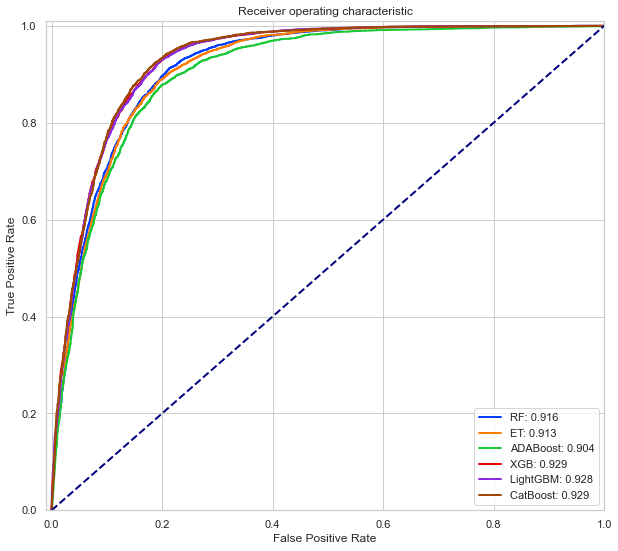

In [22]:
res2plot = []
true = df[target].sort_index()
for result in [modelRF, modelET, modelADA, modelXGB, modelLGBM, modelCB]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)